## Evaluating algorithms and KNN

我們將這些數據集分為了兩個部分，
- 第一部分用來構造分類器，因此稱為訓練集；
- 另一部分 用來評估分類器的結果，因此稱為測試集。

訓練集和測試集在數據挖掘中很常用。數據挖掘工程師不會用同一個數據集去訓練和測試程序。因為如果使用訓練集去測試分類器，得到的結果肯定是百分之百準確的。

換種說法，在評價一個數據挖掘算法的效果時，如果用來測試的數據集是訓練集本身的一個 子集，那結果會極大程度趨向於好，所以這種做法不可取。將數據集拆分成一大一小兩個部分的做法就產生了，前者用來訓練，後者用來測試。不過這種做法似乎也有問題：如果分割的時候不湊巧，就會引發異常。

比如，若測試集中的籃球運動員恰巧都很矮，她們就會被歸為馬拉松運動員；如果又矮又 輕，則會被歸為體操運動員。使用這樣的測試集會造成評分結果非常低。相反的情況也有可能出現，使評分結果趨於100%準確。無論哪種情況發生，都不是一種真實 的評價。

## 交叉驗證

我們可以用第一部分做訓練集，第二部分做測試集，然後再反過來，取兩次測試的平均結果。
我們可以將數據集分成三份，用兩個部分來做訓練集，一個部分來做測試集，迭代三次：
- 1. 使用Part 1和Part 2訓練, 使用Part 3測試； 
- 2. 使用Part 1和Part 3訓練，使用Part 2測試； 
- 3. 使用Part 2和Part 3訓練，使用Part 1測試； 
最後取三次測試的平均結果。

## ten fold cross validation 十折交叉驗證

數據集「隨機分割」成十等份(即使是同一個人進行檢驗，如果兩次使用了不同的分法，得到的結果也會有差異)，每次用9份做訓練集，1份做測試集，迭代10次。假設我有一個分類器能判斷某個人是否是籃球運動員。

- 我的數據集包含 500個運動員和500個普通人。
- 將數據分成10份 每個桶中會放50個籃球運動員，50個普通人，一共100人。
- 1. 每次迭代我們保留一個桶，比如第一次迭代保留木桶1，第二次保留木桶2。 
- 2. 我們使用剩餘的9個桶來訓練分類器，比如第一次迭代使用木桶2至10來訓練。 
- 3. 我們用剛才保留的一個桶來進行測試，並記錄結果，比如：35個籃球運動員分類正確， 29個普通人分類正確。
- (重複10次) 並合併結果

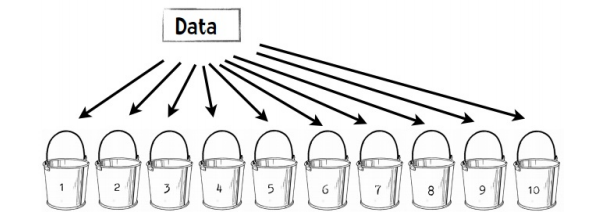

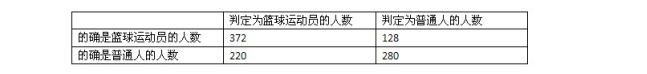

## k-fold cross-validation K折交叉驗證(Leave-one-out)

通過十折交叉驗證得到的評價結果肯定會比二折或者三折來得準確，畢竟我們使用了90% 的 數據進行訓練，而非二折驗證中的50%。好，既然十折交叉驗證效果那麼好，我們為何不做一個N折交叉驗證？ 

在十折交叉驗證中，我們需要將數據隨機等分成十份，因此 A 和 B 的分法很有可能是不一樣的。這樣一來，她們的訓練集和測試集也都不相同了，得到的結果自然不同。即使是同一個人進行檢驗，如果兩次使用了不同的分法，得到的結果也會有差異。

- 優點在 K 折交叉驗證得到的結果總是相同的，確定性高
- 最大的缺點是計算時間很長。假設我們1000條記錄的數據集，使用十折交叉需要10分鐘
- 而K折交叉驗證則需要 16 個小時。如果我們的數據集更大，檢驗時間就更長了
- 所以說，K折交叉驗證對小數據集是合適的，但大多數情況下我們會選擇十折交叉驗證

In [1]:
# 將數據等分成十份
import random

def buckets(filename, bucketName, separator, classColumn):
    # put the data in 10 buckets
    numberOfBuckets = 10
    data = {}
    # first read in the data and divide by category
    with open(filename) as f:
        lines = f.readlines()
        
    for line in lines:
        if separator != '\t':
            line = line.replace(separator, '\t')
        # first get the category
        category = line.split()[classColumn]
        data.setdefault(category, [])
        data[category].append(line)
        
    # initialize the buckets
    buckets = []
    for i in range(numberOfBuckets):
        buckets.append([])   
    
    # now for each category put the data into the buckets
    for k in data.keys():
        #randomize order of instances for each class
        random.shuffle(data[k])
        bNum = 0
        # divide into buckets
        for item in data[k]:
            buckets[bNum].append(item)
            bNum = (bNum + 1) % numberOfBuckets

    # write to file
    for bNum in range(numberOfBuckets):
        f = open("%s-%02i" % (bucketName, bNum + 1), 'w')
        for item in buckets[bNum]:
            f.write(item)
        f.close()

## KNN with ten fold cross validation KNN十折交叉驗證

我們需要進行以下幾步： 
- 修改初始化方法，只讀取九個桶中的數據作為訓練集； 
- 增加一個方法，從第十個桶中讀取測試集； 
- 執行十折交叉驗證。

## confusion matrix 混淆矩陣 + fold cross-validation 十折交叉驗證

In [10]:
import copy
class Classifier:
    def __init__(self, bucketPrefix, testBucketNumber, dataFormat):
        self.medianAndDeviation = []

        # reading the data in from the file
        self.format = dataFormat.strip().split('\t')
        self.data = []
        # for each of the buckets numbered 1 through 10:
        for i in range(1, 11):
            # if it is not the bucket we should ignore, read in the data
            if i != testBucketNumber:
                filename = "%s-%02i" % (bucketPrefix, i)
                f = open(filename)
                lines = f.readlines()
                f.close()
                for line in lines:
                    fields = line.strip().split('\t')
                    ignore = []
                    vector = []
                    for j in range(len(fields)):
                        
                        if self.format[j] == 'num':
                            vector.append(float(fields[j]))
                        elif self.format[j] == 'comment':
                            ignore.append(fields[j])
                        elif self.format[j] == 'class':
                            classification = fields[j]
                    self.data.append((classification, vector, ignore))
        self.rawData = copy.deepcopy(self.data)
        # get length of instance vector
        self.vlen = len(self.data[0][1])
        # now normalize the data
        for i in range(self.vlen):
            self.normalizeColumn(i)
 
    ##################################################
    ###
    ###  CODE TO COMPUTE THE MODIFIED STANDARD SCORE

    def getMedian(self, alist):
        """return median of alist"""
        if alist == []:
            return []
        blist = sorted(alist)
        length = len(alist)
        if length % 2 == 1:
            # length of list is odd so return middle element
            return blist[int(((length + 1) / 2) -  1)]
        else:
            # length of list is even so compute midpoint
            v1 = blist[int(length / 2)]
            v2 =blist[(int(length / 2) - 1)]
            return (v1 + v2) / 2.0
        

    def getAbsoluteStandardDeviation(self, alist, median):
        """given alist and median return absolute standard deviation"""
        sum = 0
        for item in alist:
            sum += abs(item - median)
        return sum / len(alist)


    def normalizeColumn(self, columnNumber):
        """given a column number, normalize that column in self.data"""
        # first extract values to list
        col = [v[1][columnNumber] for v in self.data]
        median = self.getMedian(col)
        asd = self.getAbsoluteStandardDeviation(col, median)
        #print("Median: %f   ASD = %f" % (median, asd))
        self.medianAndDeviation.append((median, asd))
        for v in self.data:
            v[1][columnNumber] = (v[1][columnNumber] - median) / asd


    def normalizeVector(self, v):
        """We have stored the median and asd for each column.
        We now use them to normalize vector v"""
        vector = list(v)
        for i in range(len(vector)):
            (median, asd) = self.medianAndDeviation[i]
            vector[i] = (vector[i] - median) / asd
        return vector
    ###
    ### END NORMALIZATION
    ##################################################

    def testBucket(self, bucketPrefix, bucketNumber):
        """Evaluate the classifier with data from the file
        bucketPrefix-bucketNumber"""
        
        filename = "%s-%02i" % (bucketPrefix, bucketNumber)
        f = open(filename)
        lines = f.readlines()
        totals = {}
        f.close()
        for line in lines:
            data = line.strip().split('\t')
            vector = []
            classInColumn = -1
            for i in range(len(self.format)):
                if self.format[i] == 'num':
                      vector.append(float(data[i]))
                elif self.format[i] == 'class':
                      classInColumn = i
            theRealClass = data[classInColumn]
            classifiedAs = self.classify(vector)
            totals.setdefault(theRealClass, {})
            totals[theRealClass].setdefault(classifiedAs, 0)
            totals[theRealClass][classifiedAs] += 1
        return totals

    def manhattan(self, vector1, vector2):
        """Computes the Manhattan distance."""
        return sum(map(lambda v1, v2: abs(v1 - v2), vector1, vector2))


    def nearestNeighbor(self, itemVector):
        """return nearest neighbor to itemVector"""
        return min([ (self.manhattan(itemVector, item[1]), item)
                     for item in self.data])
    
    def classify(self, itemVector):
        """Return class we think item Vector is in"""
        return(self.nearestNeighbor(self.normalizeVector(itemVector))[1][0])
 

       
def tenfold(bucketPrefix, dataFormat):
    results = {}
    for i in range(1, 11):
        c = Classifier(bucketPrefix, i, dataFormat)
        t = c.testBucket(bucketPrefix, i)
        for (key, value) in t.items():
            results.setdefault(key, {})
            for (ckey, cvalue) in value.items():
                results[key].setdefault(ckey, 0)
                results[key][ckey] += cvalue
                
    # now print results
    categories = list(results.keys())
    categories.sort()
    print(   "\n       Classified as: ")
    header =    "        "
    subheader = "      +"
    for category in categories:
        header += category + "   "
        subheader += "----+"
    print (header)
    print (subheader)
    total = 0.0
    correct = 0.0
    for category in categories:
        row = category + "    |"
        for c2 in categories:
            if c2 in results[category]:
                count = results[category][c2]
            else:
                count = 0
            row += " %2i |" % count
            total += count
            if c2 == category:
                correct += count
        print(row)
    print(subheader)
    print("\n%5.3f percent correct" %((correct * 100) / total))
    print("total of %i instances" % total)


tenfold("input/mpgData/mpgData",
        "class	num	num	num	num	num	comment")


       Classified as: 
        10   15   20   25   30   35   40   45   
      +----+----+----+----+----+----+----+----+
10    |  5 |  8 |  0 |  0 |  0 |  0 |  0 |  0 |
15    |  8 | 63 | 14 |  1 |  0 |  0 |  0 |  0 |
20    |  0 | 14 | 67 |  8 |  5 |  1 |  1 |  0 |
25    |  0 |  1 | 13 | 35 | 22 |  6 |  1 |  1 |
30    |  0 |  1 |  3 | 17 | 21 | 14 |  5 |  2 |
35    |  0 |  0 |  2 |  7 | 10 | 13 |  5 |  1 |
40    |  0 |  0 |  1 |  0 |  5 |  5 |  0 |  0 |
45    |  0 |  0 |  0 |  2 |  1 |  1 |  0 |  2 |
      +----+----+----+----+----+----+----+----+

52.551 percent correct
total of 392 instances


## Kappa指標 

除了使用十折交叉驗證和混淆矩陣來對分類器進行評估。上一節中我們對加侖公里數分類器的評價結果是53.316%的正確率，那這個結果是好是壞呢？

我們就需要使用一個新的指標：Kappa指標。可以用來評價分類器的效果比隨機分類要好多少。